# Comparison of the supervised models
    All the hyperparmeters values were entered below.
    The data was scaled.
    The AUC/ROC was calculated.
    The Accuracy was calculated for each.
    The best model was picked and the Recall and Prcision was calculated.
    The feature importance was also calculated.

    1.) Random Forest
    2.) Random Forest ADA Boost
    3.) Extreme Gradient Boost

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from time import time

#from pandas.tools.plotting import scatter_matrix


#from IPython.display import display
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

#from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn import ensemble




from sklearn.metrics import mean_squared_error
sns.set(style="darkgrid")


%matplotlib inline
#warnings.filterwarnings('ignore')
#!pip install autopep8

In [2]:
df = pd.read_csv('lending_club_le.csv', index_col=0)
y = df['bad_loan']
X = df.drop(['bad_loan'], axis=1)

In [3]:
X.shape, y.shape

((87923, 41), (87923,))

In [4]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70338, 41), (17585, 41), (70338,), (17585,))

------

# Model comparison of accuracy score

These are the tuned values from the previous notebook

In [6]:
rf_final = ensemble.RandomForestClassifier(bootstrap=True,
                                           max_depth=15,
                                           max_features=10,
                                           min_samples_leaf=10,
                                           min_samples_split=2,
                                           n_estimators=18)

In [7]:
'''These are the tuned models from the previous notebook.
It will first calculate the Accuracy score, the confusion 
matrix,the test/holdout score, the cross validation and the
classification report of each model'''
models = []
accScore = []
rocaucScore = []
names = []

print('---The baseline score is 0.7483---\n')
print('\t   Accuracy\t\t    ROC\n\t score\t  std\t\tscore\t  std')


models.append(('RFC',
               ensemble.RandomForestClassifier(bootstrap=True,
                                               max_depth=15,
                                               max_features=10,
                                               min_samples_leaf=10,
                                               min_samples_split=2,
                                               n_estimators=18)))

models.append(('ADA',
               AdaBoostClassifier(base_estimator=rf_final,
                                  n_estimators=7)))

models.append(('XGB',
               XGBClassifier(max_depth=12,
                             n_estimators=20,
                             learning_rate=0.03,
                             subsample=0.1,
                             colsample_bytree=0.5,
                             colsample_bylevel=0.5)))


for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=42)
    cv_accScore = model_selection.cross_val_score(model,
                                                 X_train,
                                                 y_train,
                                                 cv=5,
                                                 scoring='accuracy')
    cv_rocaucScore = model_selection.cross_val_score(model,
                                                  X_train,
                                                  y_train,
                                                  cv=5,
                                                  scoring='roc_auc')
    
    '''Append the cross validation scores for the accuracy and the 
    ROC/AUC scores and print the results.'''
    
    accScore.append(cv_accScore)
    rocaucScore.append(cv_rocaucScore)
    names.append(name)
    msg = "%s:\t%.4f (%.4f) \t%.4f (%.4f)" % (name, cv_accScore.mean(
    ), cv_accScore.std(), cv_rocaucScore.mean(), cv_rocaucScore.std())
    print(msg)
print('----------------------------------------------------------\n')


'''This is where the confusion matrix, holdout and cross validation 
is computed for each model'''
for name, model in models:
    model.fit(X_train, y_train)
    y_pred2 = model.predict(X_test)
    names.append(name)

    print('\n', name, '\nconfusion matrix \n',
          confusion_matrix(y_test, y_pred2))
    print('\nholdout accuracy score: ', accuracy_score(y_test, y_pred2))
    print('\ncross validation scores: ',
          cross_val_score(model, X_test, y_test, cv=5))
    print('\n', classification_report(y_test, y_pred2))
    print('----------------------------------------------------------\n')
    print('----------------------------------------------------------\n')

    #mse = math.sqrt(mean_squared_error(y_test, y_pred2))
    #print("MSE: %.4f RMSE: %.4f" % (mse, np.sqrt(mse)))
    #print('----------------------------------------------------------\n')'''

---The baseline score is 0.7483---

	   Accuracy		    ROC
	 score	  std		score	  std
RFC:	0.7559 (0.0019) 	0.6947 (0.0045)
ADA:	0.7592 (0.0022) 	0.7096 (0.0043)
XGB:	0.7514 (0.0007) 	0.6795 (0.0030)
----------------------------------------------------------


 RFC 
confusion matrix 
 [[12874   255]
 [ 4039   417]]

holdout accuracy score:  0.7558146147284618

cross validation scores:  [0.74815236 0.74694342 0.75632641 0.75007108 0.7539818 ]

               precision    recall  f1-score   support

           0       0.76      0.98      0.86     13129
           1       0.62      0.09      0.16      4456

   micro avg       0.76      0.76      0.76     17585
   macro avg       0.69      0.54      0.51     17585
weighted avg       0.73      0.76      0.68     17585

----------------------------------------------------------

----------------------------------------------------------


 ADA 
confusion matrix 
 [[12627   502]
 [ 3787   669]]

holdout accuracy score:  0.7560989479670174

cro

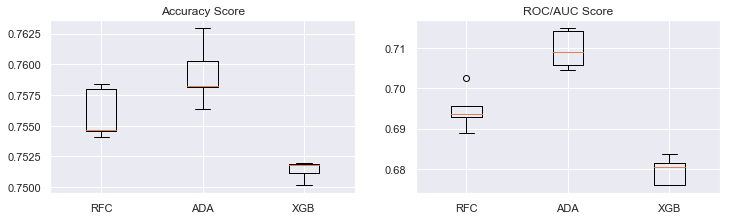

In [8]:
#Accuracy
plt.figure(figsize=(12,7))

plt.subplot(2,2,1)
plt.boxplot(accScore)
plt.title('Accuracy Score')
plt.xticks(np.arange(1,4), (names))

#ROC/AUC
plt.subplot(2,2,2)
plt.boxplot(rocaucScore)
plt.title('ROC/AUC Score')
plt.xticks(np.arange(1,4), (names))

plt.show();

## Summary

_All models have a holdout score of `~75%`.  It is able to accuracy predict bad loan applications 75% of the time. The cross validation scores for the models are range from 74% -75% which indicates stability as we also see in the plot, XGB being most stable. All models predicted to many false negatives which is not agood thing. They are the loans that were predicted as good but were actually bad. The  `False Negatives` are loans which do not get paid back._

_Recall is the ratio of correctly predicted positive observations to the all observations in actual class. The question recall answers is: Of all the loans that are truly good, how many did the model label correctly? RFC has a recall of ~100% but we will discuss this further after we calculate the ROC scores._

_Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answers is of all loans that are labeled as good, how many actually were good? The RFC model has a ~75% precision, which is pretty good._

_Now looking at the ROC scores, XGB has the better recall score but has the lowest ROC score.  ADABoost can identify bad loans, which means it also has a high recall score. But I would still stick with RFC becasue it also has a high ROC score, accuracy score and high recall._

----

## Compute and plot ROC Curve and Confusion Matrix

In [40]:
def confMatrix(name,model,X_train,y_train,X_test,y_test):  
    
    '''Compute and plot the ROC/AUC curve and the 
    confusion matrix.  Calculate the Precision, Recall
    and the F1 scores'''
    
    confmtx = confusion_matrix(y_test, model.predict(X_test))
    tn, fp, fn, tp = [i for i in confmtx.ravel()]

    ypred_train = model.predict_proba(X_train)[:, 1]
    ypred_test = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_train, ypred_train)
    fpr1, tpr1, thresholds = roc_curve(y_test, ypred_test)
    roc_auc = auc(fpr, tpr)
    ### plot the RocAuc Curve  
    plt.figure(figsize=(12,7))
    plt.subplot(2,2,1)
    plt.plot(fpr, tpr, color='b')
    plt.plot(fpr1, tpr1, color='g', label="20%holdout")
    plt.legend(['train', '20%holdout'])
    plt.title(name+ 'ROC Curve ')
    plt.xlabel('False Positive Rate(1-Specificity)\n FP/(FP + TN)')
    plt.ylabel('True Positive Rate(Sensitivity)\n TP/(TP + FN)')
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    plt.plot([0, 1], [0, 1], 'k--')
    # plt.tight_layout()
    

    ### plot the confusion matrix
    plt.subplot(2,2,2)
    ax = sns.heatmap(confmtx, annot=True, cmap='Purples',
                     annot_kws={"size": 12}, fmt='g')
    labels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for k, v in enumerate(ax.texts):
        v.set_text(v.get_text() + "\n" + labels[k])
    plt.title(name+ 'Confusion Matrix\nTest Data')
    #ax.xaxis.set_ticklabels(['good loan', 'bad loan'])
    #ax.yaxis.set_ticklabels(['good loan', 'bad loan'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show();
    
    ### calculate the confusion matrix        
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*(precision * recall) / (precision + recall)
    print('Precision: {:.4f}\tRecall: {:.4f}\t\tF1 Score: {:.4}\tAUC: {:.4}'.format(
        precision, recall, f1,roc_auc))

# Random Forest Evaluation 

    - ROC curve plot
    - confusion matrix
    - F1Score, Precision, Recall

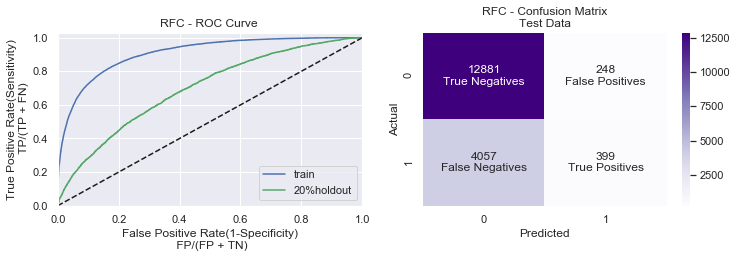

Precision: 0.6167	Recall: 0.0895		F1 Score: 0.1564	AUC: 0.9076


In [41]:
RFC=rf_final.fit(X_train, y_train)
confMatrix('RFC - ',rf_final,X_train,y_train,X_test,y_test) 

Our target is to predict bad loans.  The False Negative loans are loans which were actually bad but was predicted as good, they are loans that were approved that didn't get paid off. For a good model the False Negatives should be as small as possible.  So this means that the recall has to be high, but for this model clearly `9%` isn't a high percentage.  Of the `4456` (4057+399) positive loans we were only able to predict `413`, which is `9%`.

# ADABoost Evaluation 

    - ROC curve plot
    - confusion matrix
    - F1Score, Precision, Recall

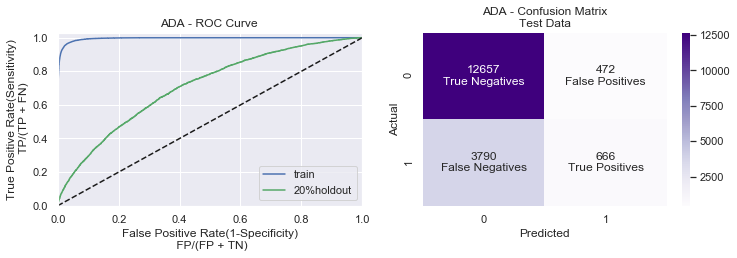

Precision: 0.5852	Recall: 0.1495		F1 Score: 0.2381	AUC: 0.9956


In [42]:
ada_final = AdaBoostClassifier(base_estimator=rf_final,
                               n_estimators=7)
ADA=ada_final.fit(X_train, y_train)
confMatrix('ADA - ',ada_final,X_train,y_train,X_test,y_test) 

Again there are too many False Negative loans predicted for ADABoost model.  The recall is `15%` and of the `4456` positive loans we were only able to predict `666`. We can see in the ROC curve that the positive rate of the train model increases a lot faster than the False negatives.

# XGB Evaluation 

    - ROC curve plot
    - confusion matrix
    - F1Score
    - weighted model

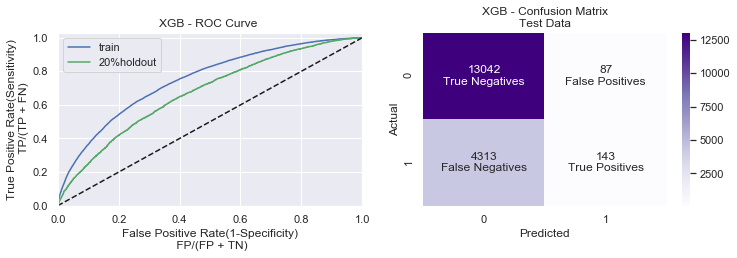

Precision: 0.6217	Recall: 0.0321		F1 Score: 0.06103	AUC: 0.7479


In [43]:
xgb_final = XGBClassifier(max_depth=12,
                             n_estimators=20,
                             learning_rate=0.03,
                             subsample=0.1,
                             colsample_bytree=0.5,
                             colsample_bylevel=0.5)

XGB = xgb_final.fit(X_train, y_train)
confMatrix('XGB - ',xgb_final,X_train,y_train,X_test,y_test) 

We will run this model to see what it is before we add the weight parameter. Again there are too many False Negative loans predicted for XGBoost model.  The recall is `3%`, so of the `4456` positive loans we were only able to predict `143`.

# XGBoost weighted model to increase the recall
Due to the model not predicting the False Negatives, weights were added.  This will increase the Recall while decreasing the accuracy.  We are better off predicting FN than trying to get a high accuracy score.  

In [50]:
weights = [1,3.5,4,4.5,5,5.5,6,6.5,14]
for x in weights:
    xgb_bal = XGBClassifier(max_depth=12,
                             n_estimators=20,
                             learning_rate=0.03,
                             subsample=0.1,
                             colsample_bytree=0.5,
                             colsample_bylevel=0.5,
                            scale_pos_weight=x)
    xgb_bal.fit(X_train, y_train)
    predictions = xgb_bal.predict(X_test)

    print('Weight of ', str(x))

    print('Recall Score: {:.2f}'.format(recall_score(y_test, predictions)))

    print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, predictions)))

    print('\nConfusion Matrix \n', confusion_matrix(y_test, predictions))
    print('----------------------\n')
    print('----------------------\n')

Weight of  1
Recall Score: 0.03
Accuracy Score: 0.75

Confusion Matrix 
 [[13042    87]
 [ 4313   143]]
----------------------

----------------------

Weight of  3.5
Recall Score: 0.43
Accuracy Score: 0.70

Confusion Matrix 
 [[10379  2750]
 [ 2541  1915]]
----------------------

----------------------

Weight of  4
Recall Score: 0.50
Accuracy Score: 0.68

Confusion Matrix 
 [[9799 3330]
 [2242 2214]]
----------------------

----------------------

Weight of  4.5
Recall Score: 0.53
Accuracy Score: 0.66

Confusion Matrix 
 [[9279 3850]
 [2105 2351]]
----------------------

----------------------

Weight of  5
Recall Score: 0.57
Accuracy Score: 0.64

Confusion Matrix 
 [[8784 4345]
 [1916 2540]]
----------------------

----------------------

Weight of  5.5
Recall Score: 0.61
Accuracy Score: 0.62

Confusion Matrix 
 [[8151 4978]
 [1749 2707]]
----------------------

----------------------

Weight of  6
Recall Score: 0.64
Accuracy Score: 0.60

Confusion Matrix 
 [[7672 5457]
 [1585 2871]

The initial model has a `Recall Score: 0.03` and Accuracy Score: 0.75, now with a weight of 5.5 the weighted model has a `Recall Score: 0.61` and Accuracy Score: 0.62.  We lost some accuracy but increased by 0.58.

No Weight


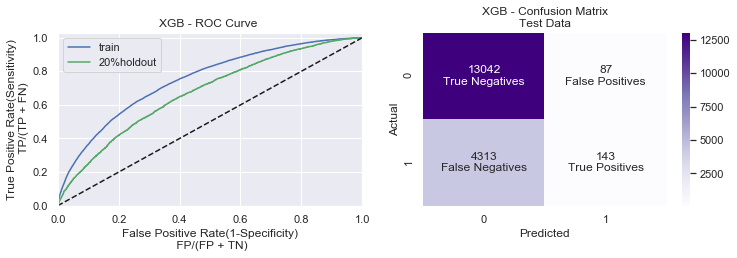

Precision: 0.6217	Recall: 0.0321		F1 Score: 0.06103	AUC: 0.7479

Weighted Model


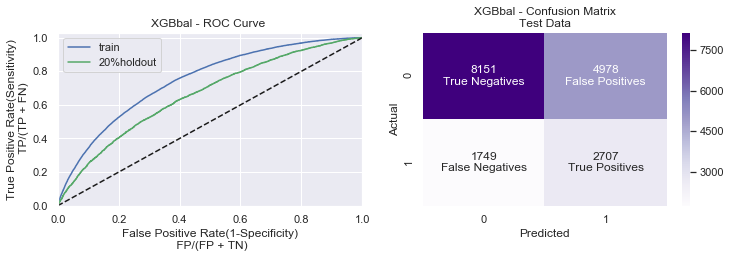

Precision: 0.3522	Recall: 0.6075		F1 Score: 0.4459	AUC: 0.7453


In [48]:
xgb_bal = XGBClassifier(max_depth=12,
                             n_estimators=20,
                             learning_rate=0.03,
                             subsample=0.1,
                             colsample_bytree=0.5,
                             colsample_bylevel=0.5,
                            scale_pos_weight=5.5)

XGBxeight=xgb_bal.fit(X_train, y_train)

print('No Weight')
confMatrix('XGB - ',xgb_final,X_train,y_train,X_test,y_test) 

print('\nWeighted Model')
confMatrix('XGBbal - ',xgb_bal,X_train,y_train,X_test,y_test) 

---

# Feature Importance

___RFC Feature Importance___

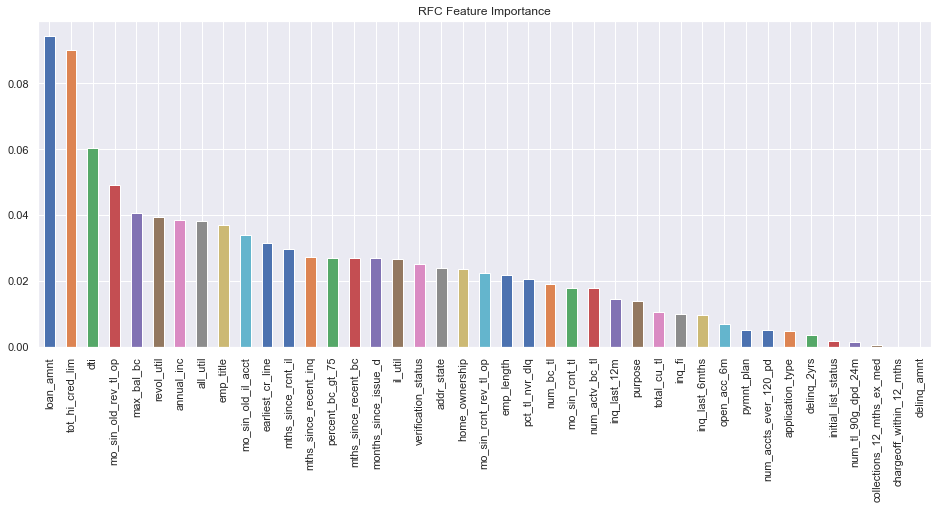

In [16]:
headers = ["feature", "score"]
values = sorted(
    zip(X_train.columns, rf_final.feature_importances_), key=lambda x: x[1] * -1)
dfFeat = pd.DataFrame(np.array(values), columns=list(headers))
#dfFeat.head(10)
plt.figure(figsize=(16, 6))
plt.title('RFC Feature Importance')

feat_importances = pd.Series(
    rf_final.feature_importances_, index=X_train.columns)
feat_importances.nlargest(41).plot(kind='bar');

In [17]:
feat_importances.nlargest(10)

loan_amnt               0.094187
tot_hi_cred_lim         0.090034
dti                     0.060404
mo_sin_old_rev_tl_op    0.049218
max_bal_bc              0.040628
revol_util              0.039391
annual_inc              0.038620
all_util                0.038270
emp_title               0.037103
mo_sin_old_il_acct      0.034114
dtype: float64

___ADA Feature Importance___

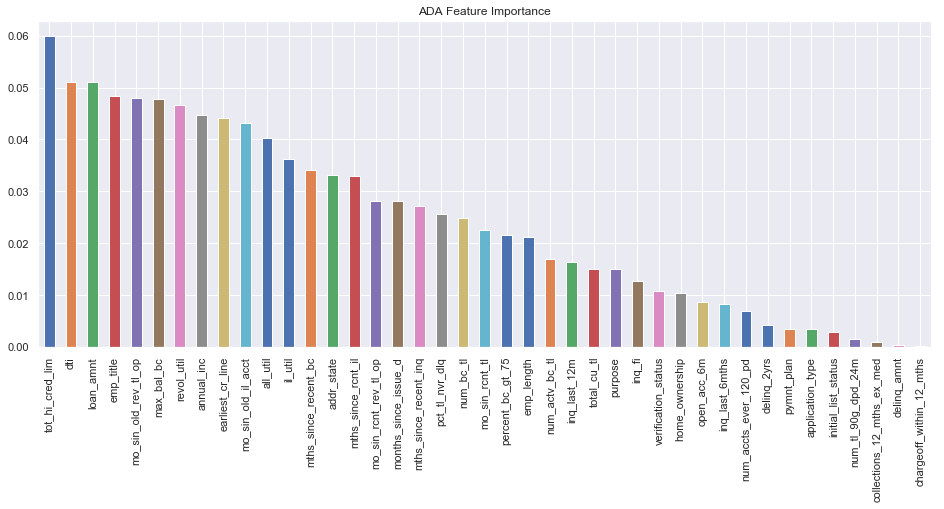

In [18]:
plt.figure(figsize=(16, 6))
plt.title('ADA Feature Importance')

feat_ada = pd.Series(
    ada_final.feature_importances_, index=X_train.columns)
feat_ada.nlargest(41).plot(kind='bar');

___XGB Feature Importance___

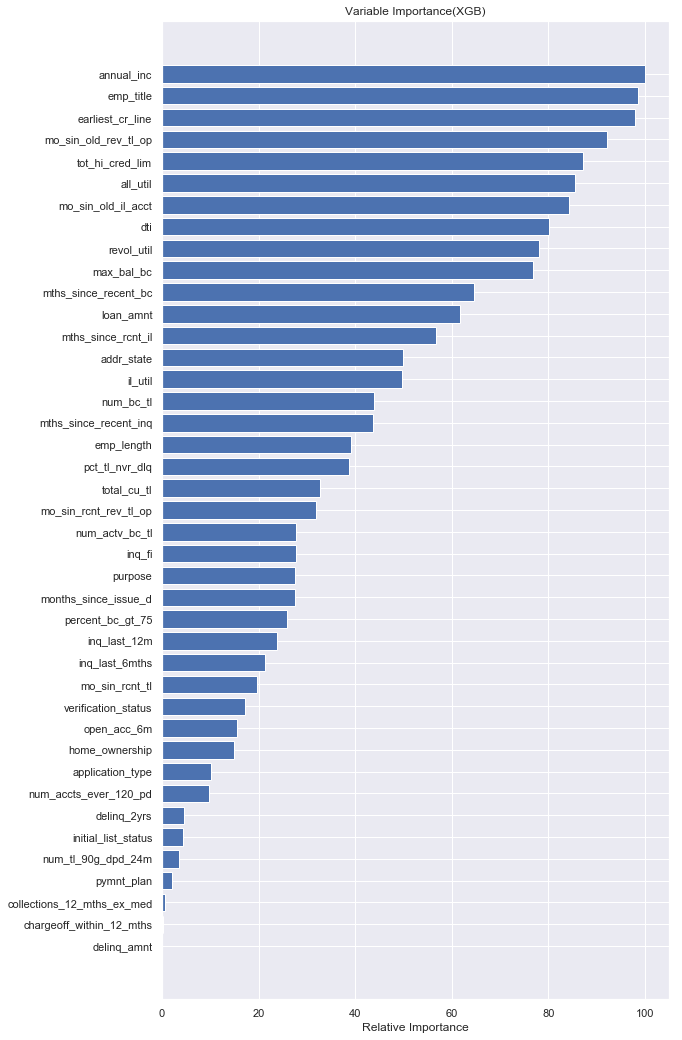

In [19]:
xgb_fea_imp = pd.DataFrame(list(xgb_final.get_booster().get_fscore().items()),
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)
fig = plt.figure(figsize=(20, 18))
feature_importance = xgb_final.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance(XGB)')
plt.show()

# Conclusion
The RFC model is able to predict a bad loan application `75%` of the time.  RFC mis-classified `53` bad loan applications while ADA mis-classified `529` loans.  Overall, XGB did a poor job on predictions, it scored about the same as the baseline of`74.83%`  RFC and ADA were able to identify the positives(bad loans) as seen with the recall score.

In an attempt to increase the Recall score, the parameter scale_pos_weight was added to XGBoost.The parameter scale_pos_weight controls the balance of positive and negative weights which is useful for unbalanced classes.
There will be a trade off in the accuracy score when the weight is applied. The accuracy will decrease but it is better to have less borrowers who don’t pay back the loan than a high accuracy score for this model.
The weight of 5.5 was chosen as the ‘best’. It decreased the False Negatives from 4313 to 1749, increased the False Positives.

The models can be tuned more by dropping more of the features that don't even rank in feature importance such as `delinq_amnt`.  The XGB model was not a good choice for this model.  It didn't score above the baseline.  I think all models should be looked at again when the target variable is balanced to see if the score increases.  It would be beneficial to look at the outliers to see if it makes sense to remove some of them. I did try the SMOTE oversample and it didn't increase the accuracy, I would like to revisit the sampling and even try down sampling.